# Hotel Booking Demand Prediction

In [47]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import datetime


import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

import folium
from folium.plugins import HeatMap
import plotly.express as px

plt.style.use('fivethirtyeight')
%matplotlib inline
pd.set_option('display.max_columns', 32)

In [3]:
# reading data
df = pd.read_csv('hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [4]:
df.shape

(119390, 32)

## Data Cleaning

In [31]:
NaN = df.isna().sum()
NaN[NaN > 0] # showing columns with missing value

children         4
country        488
agent        16340
company     112593
dtype: int64

In [32]:
# find missing percentage
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(total / len(df) * 100, 2)
    return pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])

missing_percentage(df)

,Total,Percent
company,112593,94.31
agent,16340,13.69
country,488,0.41
children,4,0.00


Since we can see that column "company" has 94.31% of missing values, we will drop that column

In [34]:
df["company"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 119390 entries, 0 to 119389
Series name: company
Non-Null Count  Dtype  
--------------  -----  
6797 non-null   float64
dtypes: float64(1)
memory usage: 932.9 KB


In [35]:
df["agent"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 119390 entries, 0 to 119389
Series name: agent
Non-Null Count   Dtype  
--------------   -----  
103050 non-null  float64
dtypes: float64(1)
memory usage: 932.9 KB


In [36]:
# drop company and agent

df = df.drop(['company', 'agent'], axis=1)

In [37]:
#  drop tuples with null values
df = df.dropna(subset=['country', 'children'], axis=0)

In [42]:
df = df.reset_index(drop=True)

In [43]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [44]:
missing_percentage(df)

,Total,Percent


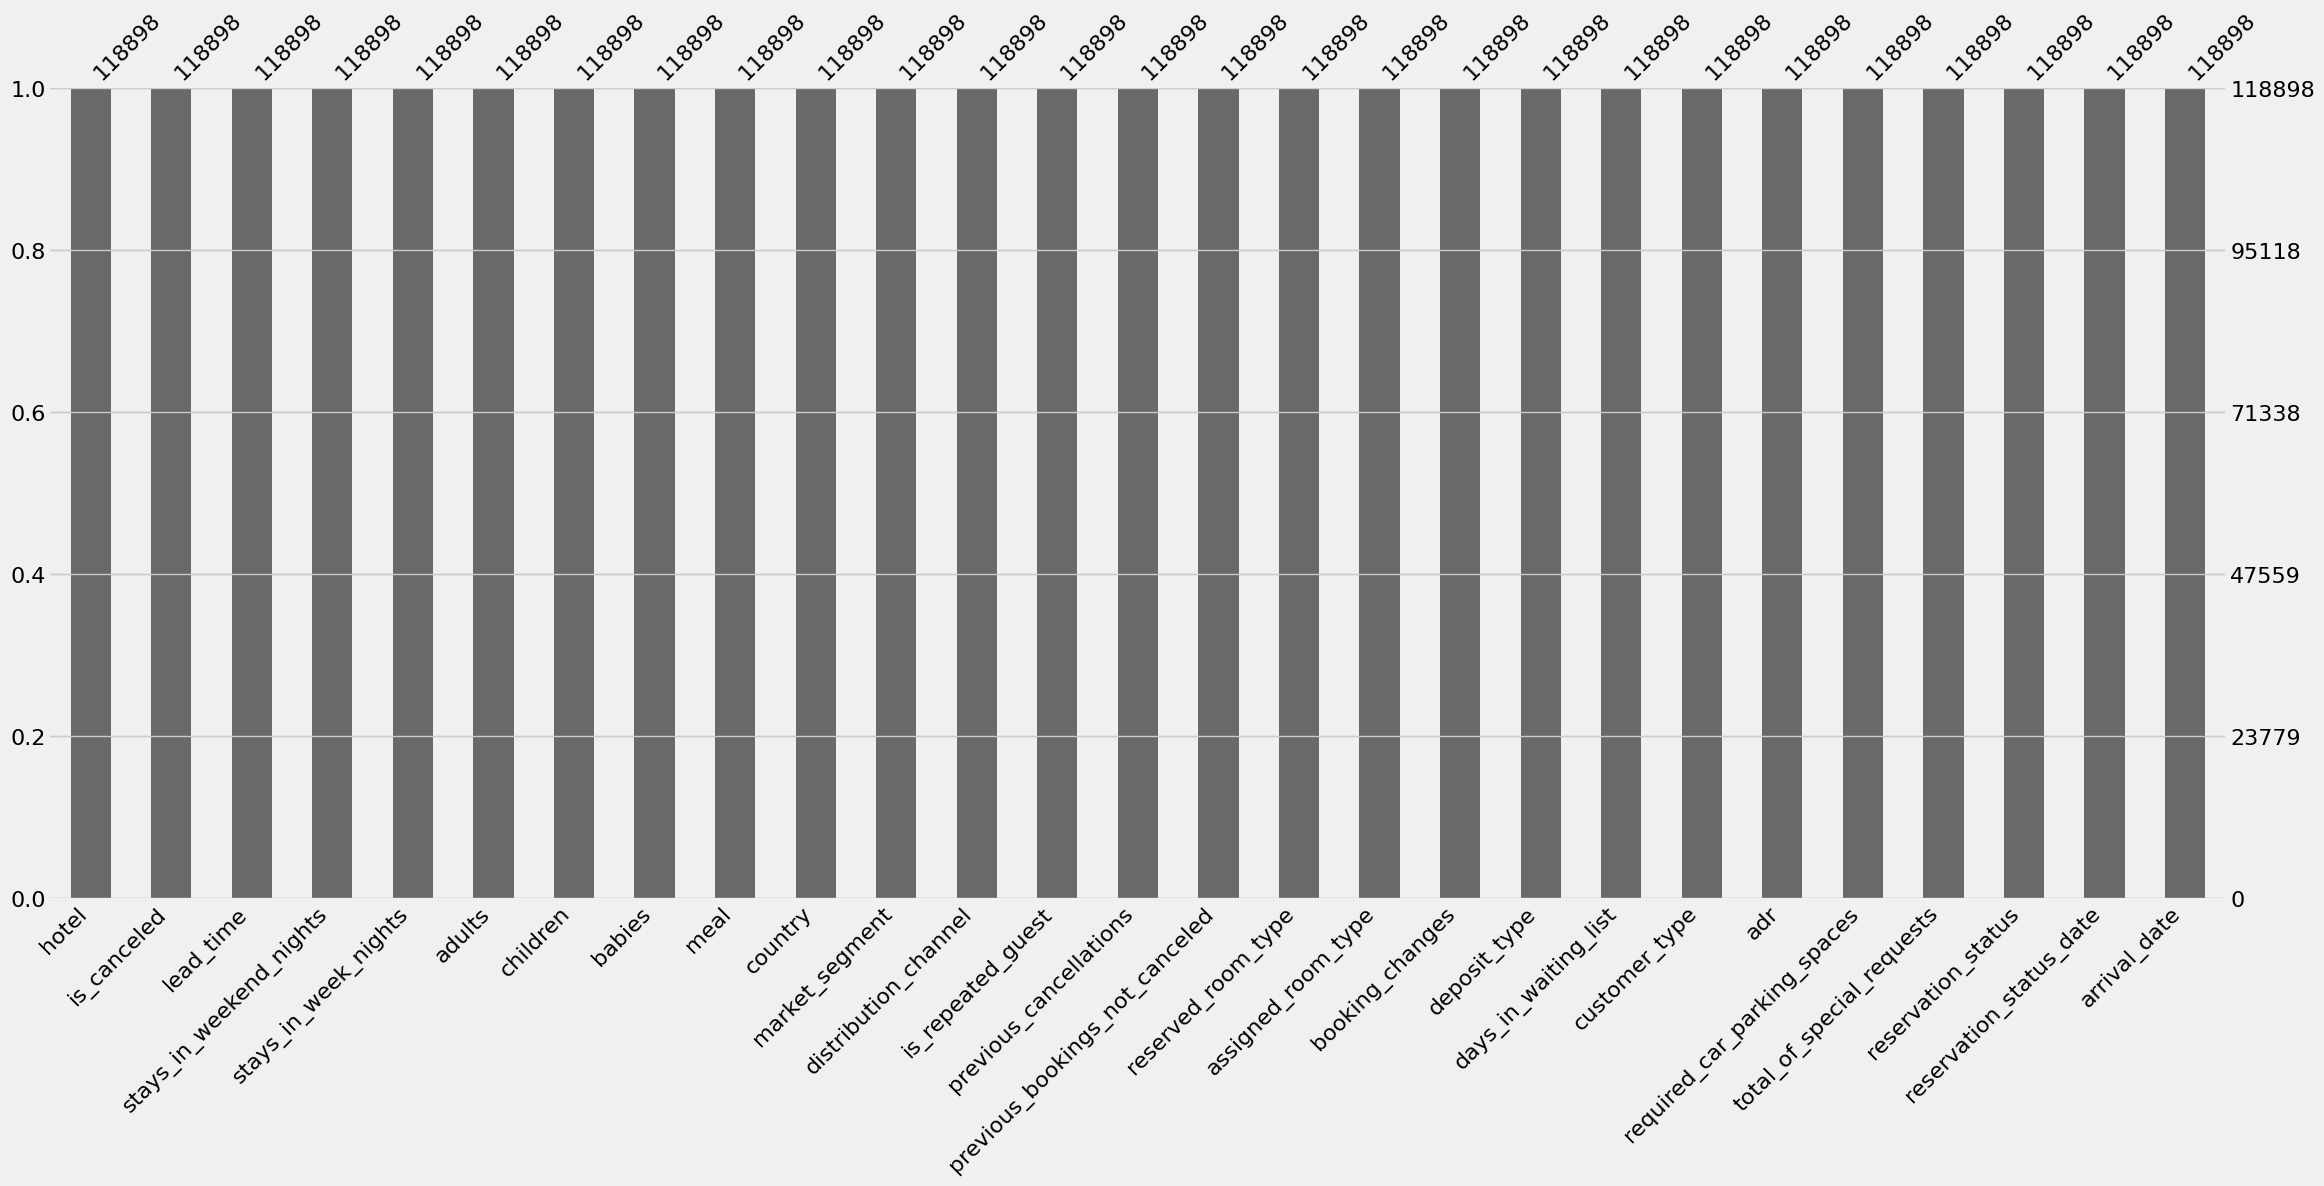

In [52]:
# visualizing null values
msno.bar(df)
plt.show()

Our data is now cleaned

In [45]:
df.shape

(118898, 30)

Let's take a look at categorical data and clean them

In [46]:
df['children'] = df['children'].astype(int)
df['children'].dtype #It is correct now!

dtype('int32')

In [48]:

# Converting string month to numerical one (Dec = 12, Jan = 1, etc.)
datetime_object = df['arrival_date_month'].str[0:3]
month_number = np.zeros(len(datetime_object))

# Creating a new column based on numerical representation of the months
for i in range(0, len(datetime_object)):
    datetime_object[i] = datetime.datetime.strptime(datetime_object[i], "%b")
    month_number[i] = datetime_object[i].month

# Float to integer conversion
month_number = pd.DataFrame(month_number).astype(int)

In [49]:
# 3 columns are merged into one
df['arrival_date'] = df['arrival_date_year'].map(str) + '-' + month_number[0].map(str) + '-' \
                       + df['arrival_date_day_of_month'].map(str)

In [50]:
# Dropping already used columns
df = df.drop(['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month',
                  'arrival_date_week_number'], axis=1)
df.head()

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
0,Resort Hotel,0,342,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-7-1
1,Resort Hotel,0,737,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-7-1
2,Resort Hotel,0,7,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-7-1
3,Resort Hotel,0,13,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-7-1
4,Resort Hotel,0,14,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-7-1


In [53]:
# adults, babies and children cant be zero at same time, so dropping the rows having all these zero at same time

filter = (df.children == 0) & (df.adults == 0) & (df.babies == 0)
df[filter]

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
2223,Resort Hotel,0,1,0,3,0,0,0,SC,PRT,Corporate,Corporate,0,0,0,A,I,1,No Deposit,0,Transient-Party,0.00,0,0,Check-Out,2015-10-06,2015-10-6
2408,Resort Hotel,0,0,0,0,0,0,0,SC,PRT,Corporate,Corporate,0,0,0,A,I,0,No Deposit,0,Transient,0.00,0,0,Check-Out,2015-10-12,2015-10-12
3180,Resort Hotel,0,36,1,2,0,0,0,SC,ESP,Groups,TA/TO,0,0,0,A,C,0,No Deposit,0,Transient-Party,0.00,0,0,Check-Out,2015-11-23,2015-11-20
3683,Resort Hotel,0,165,1,4,0,0,0,SC,PRT,Groups,TA/TO,0,0,0,A,A,1,No Deposit,122,Transient-Party,0.00,0,0,Check-Out,2016-01-04,2015-12-30
3707,Resort Hotel,0,165,2,4,0,0,0,SC,PRT,Groups,TA/TO,0,0,0,A,C,1,No Deposit,122,Transient-Party,0.00,0,0,Check-Out,2016-01-05,2015-12-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114537,City Hotel,0,107,0,3,0,0,0,BB,CHE,Online TA,TA/TO,0,0,0,A,A,1,No Deposit,0,Transient,100.80,0,0,Check-Out,2017-06-30,2017-6-27
114599,City Hotel,0,1,0,1,0,0,0,SC,PRT,Complementary,Direct,0,0,0,E,K,0,No Deposit,0,Transient,0.00,1,1,Check-Out,2017-07-01,2017-6-30
115759,City Hotel,0,44,1,1,0,0,0,SC,SWE,Online TA,TA/TO,0,0,0,A,K,2,No Deposit,0,Transient,73.80,0,0,Check-Out,2017-07-17,2017-7-15
116042,City Hotel,0,2,2,5,0,0,0,SC,RUS,Online TA,TA/TO,0,0,0,A,K,1,No Deposit,0,Transient-Party,22.86,0,1,Check-Out,2017-07-22,2017-7-15


In [54]:
df = df[~filter]
df

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
0,Resort Hotel,0,342,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-7-1
1,Resort Hotel,0,737,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-7-1
2,Resort Hotel,0,7,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-7-1
3,Resort Hotel,0,13,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-7-1
4,Resort Hotel,0,14,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-7-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118893,City Hotel,0,23,2,5,2,0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,96.14,0,0,Check-Out,2017-09-06,2017-8-30
118894,City Hotel,0,102,2,5,3,0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,0,Transient,225.43,0,2,Check-Out,2017-09-07,2017-8-31
118895,City Hotel,0,34,2,5,2,0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,0,Transient,157.71,0,4,Check-Out,2017-09-07,2017-8-31
118896,City Hotel,0,109,2,5,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,104.40,0,0,Check-Out,2017-09-07,2017-8-31


In [65]:
# reservation_status_date, arrival_date 
# make them date parameters

df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

In [66]:
df['reservation_status_date'].info()

<class 'pandas.core.series.Series'>
Int64Index: 118728 entries, 0 to 118897
Series name: reservation_status_date
Non-Null Count   Dtype         
--------------   -----         
118728 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.8 MB


In [79]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date'],
      dtype='object')

## Data Description

hotel: This attribute represents the type of hotel where the booking was made. It has two categories: "City Hotel" and "Resort Hotel," indicating whether the booking was for a city hotel or a resort hotel.

is_canceled: This binary attribute indicates whether the booking was canceled (1 for canceled, 0 for not canceled). It is a crucial feature for understanding booking cancellation patterns.

lead_time: The number of days between the booking date and the arrival date. This feature provides insight into how far in advance guests typically make their reservations.

stays_in_weekend_nights and stays_in_week_nights: These two attributes represent the number of weekend nights (Friday and Saturday) and weeknights (Sunday through Thursday) the guest plans to stay in the hotel, respectively. They help in analyzing the length of the stay.

adults, children, and babies: These attributes indicate the number of adults, children, and babies included in the booking. They are essential for understanding the composition of guests.

meal: This attribute represents the type of meal package booked by the guest, such as "BB" (Bed & Breakfast), "HB" (Half Board), "SC" (Self Catering), "Undefined," or "FB" (Full Board).

country: The country of origin of the guest. It provides information about the geographical distribution of guests.

market_segment: This attribute represents the market segment associated with the booking, such as "Online TA" (Travel Agents), "Offline TA/TO" (Travel Agents/Tour Operators), "Groups," "Direct," "Corporate," "Complementary," or "Aviation."

distribution_channel: This attribute indicates the distribution channel used to make the booking, including "TA/TO" (Travel Agents/Tour Operators), "Direct," "Corporate," "GDS" (Global Distribution System), or "Undefined."

is_repeated_guest: A binary attribute indicating whether the guest is a repeated guest (1 for repeated guest, 0 for not).

previous_cancellations and previous_bookings_not_canceled: These attributes represent the number of previous cancellations and previous bookings that were not canceled by the guest, respectively.

reserved_room_type and assigned_room_type: These attributes specify the type of room reserved by the guest and the type of room assigned to the guest, respectively.

booking_changes: The number of changes or modifications made to the booking. It reflects how often guests modify their reservations.

deposit_type: This attribute indicates the type of deposit made for the booking and can be "No Deposit," "Non Refund," or "Refundable."

days_in_waiting_list: The number of days the booking was on the waiting list before it was confirmed.

customer_type: This attribute represents the type of customer, such as "Transient," "Transient-Party," "Contract," or "Group."

adr: Average Daily Rate, which is the average price per night of the booking.

required_car_parking_spaces: Indicates the number of car parking spaces required by the guest.

total_of_special_requests: The total number of special requests made by the guest.

reservation_status: The reservation status, which can be "Check-Out," "Canceled," or "No-Show."

reservation_status_date: The date when the reservation status was last updated.

arrival_date: The date of guest arrival.

In [80]:
# Convert hotel to Binary values

df['hotel'] = df['hotel'].map({'Resort Hotel': 0, 'City Hotel': 1})

In [81]:
# convert meals to values

df['meal'] = df['meal'].map({'SC': 0, 'BB': 1, 'HB': 2, 'FB': 3, 'Undefined': 4})

In [82]:
# convert market_segment, distribution_channel, reserved_room_type, assigned_room_type, deposit_type, customer_type, reservation_status

df['market_segment'] = df['market_segment'].map({'Direct': 0, 'Corporate': 1, 'Online TA': 2, 'Offline TA/TO': 3, 'Complementary': 4, 'Groups': 5, 'Undefined': 6, 'Aviation': 7})
df['distribution_channel'] = df['distribution_channel'].map({'Direct': 0, 'Corporate': 1, 'TA/TO': 2, 'Undefined': 3, 'GDS': 4})
df['reserved_room_type'] = df['reserved_room_type'].map({'C': 0, 'A': 1, 'D': 2, 'E': 3, 'G': 4, 'F': 5, 'H': 6, 'L': 7, 'B': 8})
df['assigned_room_type'] = df['assigned_room_type'].map({'C': 0, 'A': 1, 'D': 2, 'E': 3, 'G': 4, 'F': 5, 'I': 6, 'B': 7, 'H': 8, 'K': 9, 'P': 10, 'L': 11, 'N': 12, 'O': 13})
df['deposit_type'] = df['deposit_type'].map({'No Deposit': 0, 'Refundable': 1, 'Non Refund': 2})
df['customer_type'] = df['customer_type'].map({'Transient': 0, 'Contract': 1, 'Transient-Party': 2, 'Group': 3})
df['reservation_status'] = df['reservation_status'].map({'Check-Out': 0, 'Canceled': 1, 'No-Show': 2})


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118728 entries, 0 to 118897
Data columns (total 27 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           118728 non-null  int64         
 1   is_canceled                     118728 non-null  int64         
 2   lead_time                       118728 non-null  int64         
 3   stays_in_weekend_nights         118728 non-null  int64         
 4   stays_in_week_nights            118728 non-null  int64         
 5   adults                          118728 non-null  int64         
 6   children                        118728 non-null  int32         
 7   babies                          118728 non-null  int64         
 8   meal                            118728 non-null  int64         
 9   country                         118728 non-null  object        
 10  market_segment                  118728 non-null  int64  

## Classify variables

In [130]:
def classify_data_type(data):
    # Check for data types
    if all(isinstance(val, str) for val in data):
        return "Nominal"
    elif all(isinstance(val, int) for val in data):
        unique_values = set(data)
        if all(val == i for i, val in enumerate(sorted(unique_values))):
            return "Ordinal"
        return "Ratio"
    elif all(isinstance(val, (int, float)) for val in data):
        return "Interval"
    elif all(isinstance(val,pd.Timestamp) for val in data):
        return "Date" 
    else:
        return "Unknown"

# Classify the columns of a dataframe 
def classify_columns(df):
    columns = df.columns
    nominal_columns = []
    ordinal_columns = []
    ratio_columns = []
    interval_columns = []
    date_columns=[]
    unknown_columns = []


    for col in columns:
        data_type = classify_data_type(df[col])
        if data_type == "Nominal":
            nominal_columns.append(col)
        elif data_type == "Ordinal":
            ordinal_columns.append(col)
        elif data_type=="Ratio":
            ratio_columns.append(col)
        elif data_type=="Interval":
            interval_columns.append(col)
        elif data_type=="Date":
            date_columns.append(col)
        else:
            unknown_columns.append(col)
            
    return nominal_columns, ordinal_columns,ratio_columns,interval_columns,date_columns,unknown_columns

In [131]:
nominal_columns, ordinal_columns,ratio_columns,interval_columns,date_columns,unknown_columns = classify_columns(df)

In [132]:
print("The following columns are Nominal:\n\n", ", ".join([str(x) for x in nominal_columns]))

The following columns are Nominal:

 country


In [133]:
print("The following columns are Ordinal:\n\n", ", ".join([str(x) for x in ordinal_columns]))

The following columns are Ordinal:

 hotel, is_canceled, meal, distribution_channel, is_repeated_guest, previous_bookings_not_canceled, reserved_room_type, booking_changes, deposit_type, customer_type, total_of_special_requests, reservation_status


In [134]:

print("The following columns are Ratio:\n\n", ", ".join([str(x) for x in ratio_columns]))

The following columns are Ratio:

 lead_time, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, market_segment, previous_cancellations, assigned_room_type, days_in_waiting_list, required_car_parking_spaces


In [135]:

print("The following columns are Interval:\n\n", ", ".join([str(x) for x in interval_columns]))

The following columns are Interval:

 adr


In [136]:
print("The following columns are Date:\n\n", ", ".join([str(x) for x in date_columns]))

The following columns are Date:

 reservation_status_date, arrival_date


In [137]:

print("The following columns are Unknown:\n\n", ", ".join([str(x) for x in unknown_columns]))

The following columns are Unknown:

 


In [138]:
for i in nominal_columns:
    print(df[i].value_counts(),"\n\n")

PRT    48479
GBR    12120
FRA    10401
ESP     8560
DEU     7285
       ...  
DJI        1
BWA        1
HND        1
VGB        1
NAM        1
Name: country, Length: 177, dtype: int64 




       City Hotel      79143
       Resort Hotel    39585
Name: hotel, dtype: int64 


       BB           91789
       HB           14429
       SC           10547
       Undefined     1165
       FB             798
Name: meal, dtype: int64 


       PRT    48479
       GBR    12120
       FRA    10401
       ESP     8560
       DEU     7285
              ...  
       DJI        1
       BWA        1
       HND        1
       VGB        1
       NAM        1
Name: country, Length: 177, dtype: int64 


       Online TA        56333
       Offline TA/TO    24125
       Groups           19786
       Direct           12424
       Corporate         5099
       Complementary      726
       Aviation           235
Name: market_segment, dtype: int64 


       TA/TO        97612
       Direct       14450
       Corporate     6472
       GDS            193
       Undefined        1
Name: distribution_channel, dtype: int64 


       A    85480
       D    19151
       E     6481
       F     2887
       G     2081
       B     1111
       C      930
       H      601
       L        6
Name: reserved_room_type, dtype: int64 


       A    73830
       D    25153
       E     7730
       F     3732
       G     2535
       C     2349
       B     2150
       H      708
       I      353
       K      187
       L        1
Name: assigned_room_type, dtype: int64 


       No Deposit    103993
       Non Refund     14573
       Refundable       162
Name: deposit_type, dtype: int64 


       Transient          89046
       Transient-Party    25042
       Contract            4072
       Group                568
Name: customer_type, dtype: int64 


       Check-Out    74590
       Canceled     42936
       No-Show       1202
Name: reservation_status, dtype: int64 


In [139]:
for i in ordinal_columns:
    print(df[i].value_counts(),"\n\n")

1    79143
0    39585
Name: hotel, dtype: int64 


0    74590
1    44138
Name: is_canceled, dtype: int64 


1    91789
2    14429
0    10547
4     1165
3      798
Name: meal, dtype: int64 


2    97612
0    14450
1     6472
4      193
3        1
Name: distribution_channel, dtype: int64 


0    114977
1      3751
Name: is_repeated_guest, dtype: int64 


0     115338
1       1448
2        536
3        301
4        209
       ...  
47         1
49         1
50         1
51         1
72         1
Name: previous_bookings_not_canceled, Length: 73, dtype: int64 


1    85480
2    19151
3     6481
5     2887
4     2081
8     1111
0      930
6      601
7        6
Name: reserved_room_type, dtype: int64 


0     100830
1      12604
2       3765
3        912
4        366
5        115
6         61
7         29
8         14
9          8
10         6
13         5
14         3
15         3
17         2
16         2
12         1
18         1
11         1
Name: booking_changes, dtype: int64 


0    1039

    0    74590
    1    44138
Name: is_canceled, dtype: int64 


    0    114977
    1      3751
Name: is_repeated_guest, dtype: int64 


    0     115338
    1       1448
    2        536
    3        301
    4        209
        ...  
    47         1
    49         1
    50         1
    51         1
    72         1
Name: previous_bookings_not_canceled, Length: 73, dtype: int64 


    0     100830
    1      12604
    2       3765
    3        912
    4        366
    5        115
    6         61
    7         29
    8         14
    9          8
    10         6
    13         5
    14         3
    15         3
    17         2
    16         2
    12         1
    18         1
    11         1
Name: booking_changes, dtype: int64 


    0    69884
    1    33078
    2    12905
    3     2484
    4      339
    5       38
Name: total_of_special_requests, dtype: int64 




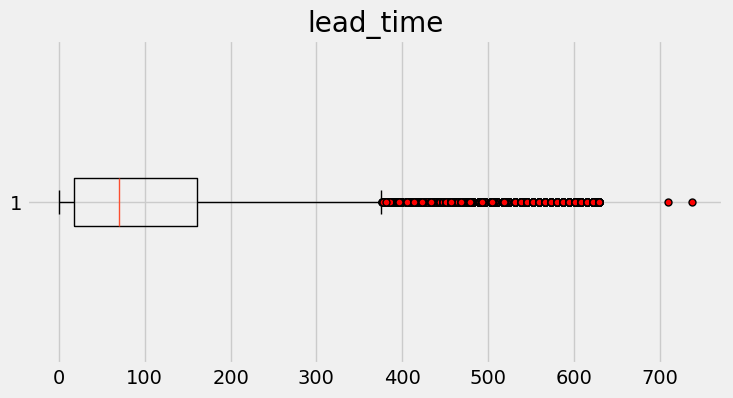

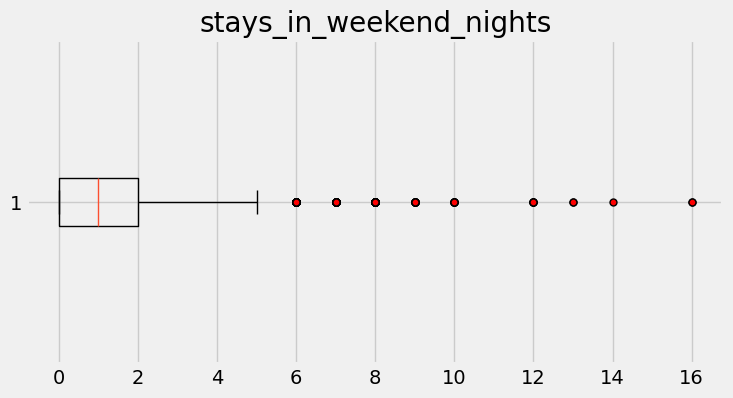

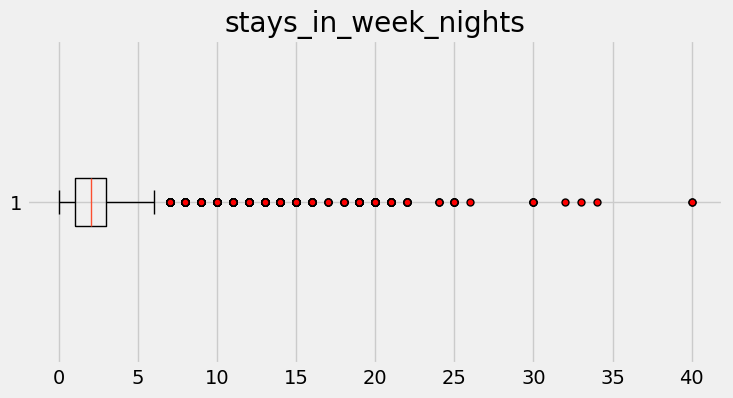

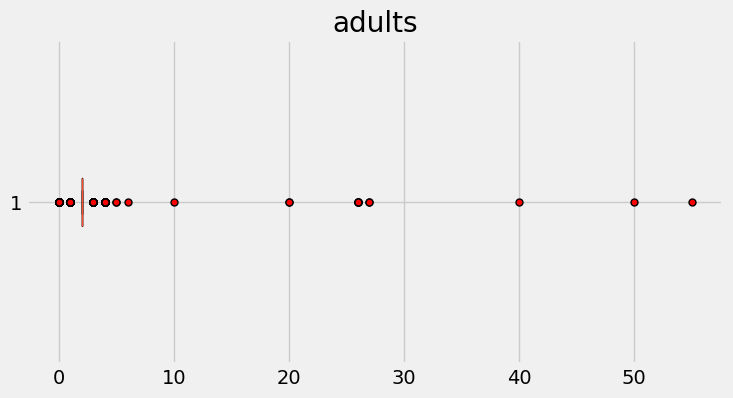

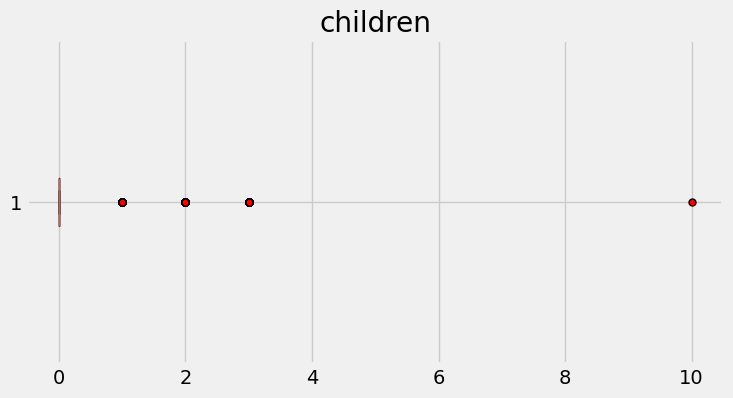

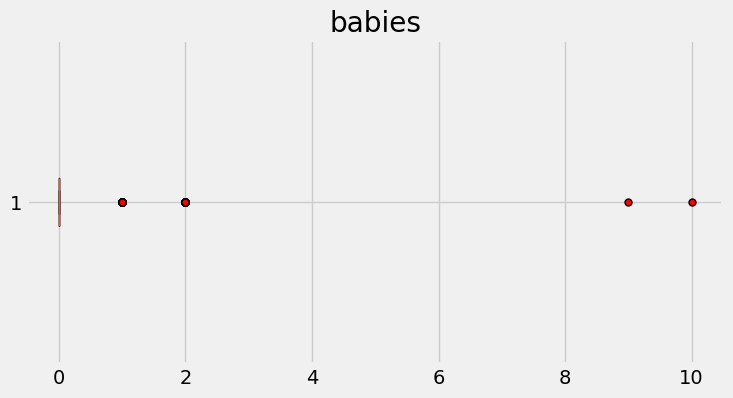

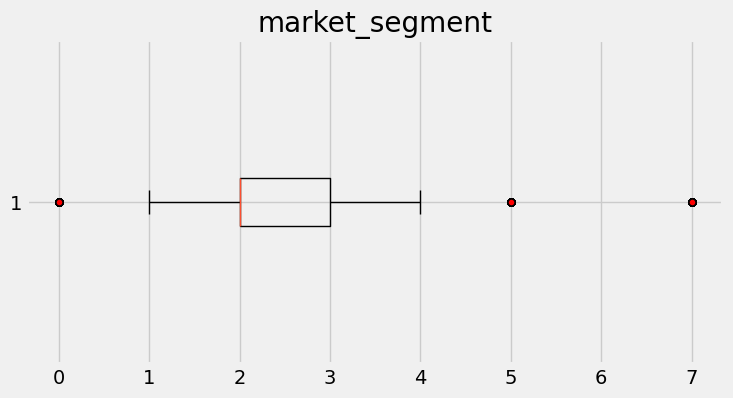

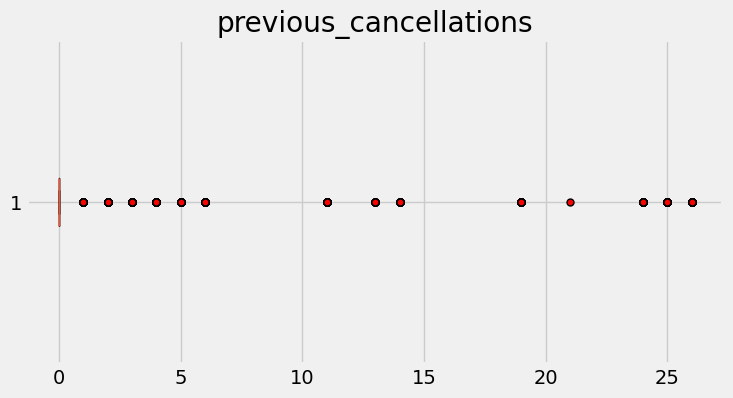

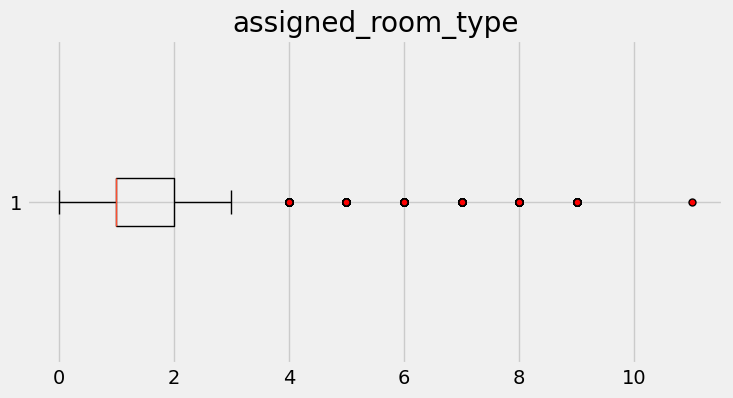

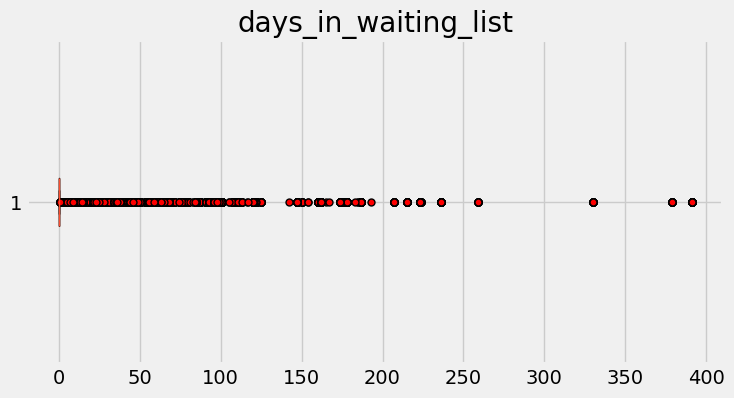

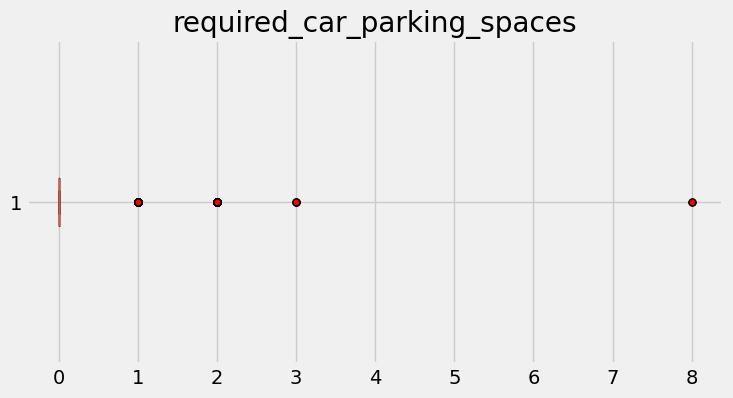

In [140]:
for i in ratio_columns:
    plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
    plt.title(i)
    
    # Create a horizontal boxplot
    plt.boxplot(df[i], vert=False, flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 5})
    # flierprops allows you to customize the appearance of outliers.
    plt.show()


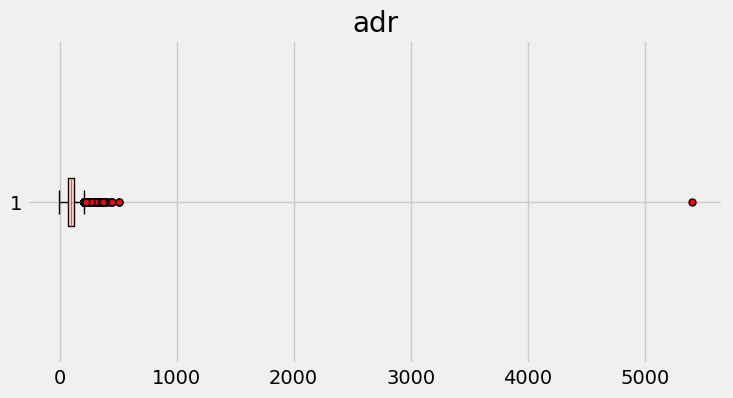

In [141]:
for i in interval_columns:
    plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
    plt.title(i)
    
    # Create a horizontal boxplot
    plt.boxplot(df[i], vert=False, flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 5})
    # flierprops allows you to customize the appearance of outliers.
    plt.show()


adr- average daily rate

In [143]:
df.describe()

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status
count,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000,118728.000000
mean,0.666591,0.371757,104.401312,0.928307,2.500918,1.861052,0.104356,0.007959,1.075576,2.473039,1.705335,0.031593,0.087208,0.131612,1.503605,1.690014,0.218828,0.246850,2.330638,0.470487,102.133442,0.061915,0.571778,0.381881
std,0.471433,0.483276,106.915284,0.992725,1.889089,0.574697,0.399439,0.097449,0.565553,1.419420,0.678988,0.174915,0.846419,1.485300,1.125863,1.353195,0.638914,0.656814,17.633065,0.836467,50.389602,0.244230,0.792740,0.506259
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,18.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,70.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,161.000000,2.000000,3.000000,2.000000,0.000000,0.000000,1.000000,3.000000,2.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.250000,126.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,737.000000,16.000000,40.000000,55.000000,10.000000,10.000000,4.000000,7.000000,4.000000,1.000000,26.000000,72.000000,8.000000,11.000000,18.000000,2.000000,391.000000,3.000000,5400.000000,8.000000,5.000000,2.000000


## Removing outlier

In [142]:
print(nominal_columns)
nominal_columns.remove('country')

['country']


In [127]:
def skewness(attr):
    for i in attr:
        skew = df[i].skew()
        if skew > 0:
            print(f"{i} is positively skewed")
        elif skew < 0:
            print(f"{i} is negatively skewed")
        else:
            print(f"{i} is normally distributed (approximately)")


In [128]:
skewness(ratio_columns)

lead_time is positively skewed
stays_in_weekend_nights is positively skewed
stays_in_week_nights is positively skewed
adults is positively skewed
children is positively skewed
babies is positively skewed
previous_cancellations is positively skewed
days_in_waiting_list is positively skewed
required_car_parking_spaces is positively skewed


In [112]:
skewness(interval_columns)

adr is positively skewed


In [122]:
skewness(ordinal_columns)

is_canceled is positively skewed
is_repeated_guest is positively skewed
previous_bookings_not_canceled is positively skewed
booking_changes is positively skewed
total_of_special_requests is positively skewed


In [123]:
skewness(nominal_columns)

hotel is negatively skewed
meal is positively skewed
market_segment is positively skewed
distribution_channel is negatively skewed
reserved_room_type is positively skewed
assigned_room_type is positively skewed
deposit_type is positively skewed
customer_type is positively skewed
reservation_status is positively skewed
